# Notebook for RDE stability analysis

Script to investigate the ECSA loss during an accelerated stress test (AST). For more information about the functions, see comments in analysis_RDE.py.

### 1. Initialization

In [73]:
%load_ext autoreload
from analysis_RDE import *
from analysis_RDE import ECSA_calculation
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


''

### 1.1 Introducting experimental parameters.

Fill in the corresponding values.

In [74]:
A_geo = 0.196               # cm2
loading = 10                # ug/cm2
ir_comp = 30                # ohm
charge_ecsa = 0.000210      # C/cm2
Pt_mass = loading * A_geo   # mg
scan_rate = 0.05            # V/s for CO stripping

index = 9                  # number of lines of info to be removed

#### 1.2 Check the reference electrode.

Chosen file: L:/P15 SEM/Linnéa/2024_04_1819/ML00/ML00_M011_Cyc0003.txt
Shift by -0.267487 V.


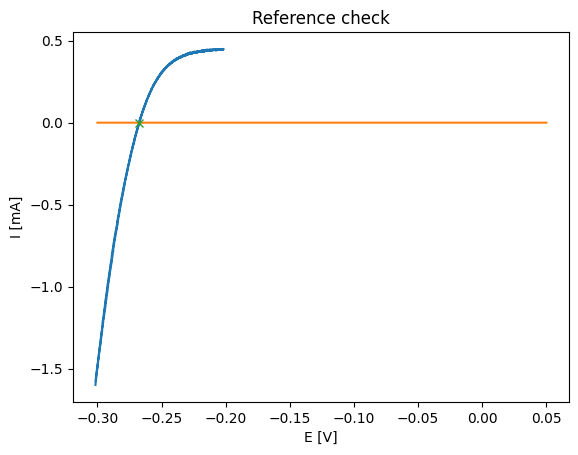

In [76]:
%autoreload
H2_file = filedialog.askopenfilename(title="Choose the file with CV under hydrogen.")
V, I = get_voltage_current(H2_file, index)
print("Chosen file:",H2_file)

x_lower_limit = -0.3
x_upper_limit = 0.05
reference = reference_check(V, I, x_lower_limit, x_upper_limit)

### 2. Choose which file(s) to analyze

#### 2.A Analysis of one file: Open the file with the interesting voltage and current data.

In [27]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_04_2324/ML00/ML00_M011_Cyc0003.txt


#### 2.B Analysis of several files: Open the files with the interesting voltage and current data.

In [29]:
nbr_files = 2  #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M035_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M038_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M041_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M044_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M047_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M050_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M053_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M056_Cyc0001.txt')


### 3. Introduce background: choose the corresponding file(s)

In [30]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M035_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M038_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M041_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M044_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M047_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M050_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M053_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_04_2324/Stability/ML00_M056_Cyc0002.txt')


### 4. Corrections
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly in Labview)

In [31]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    background_V_RHE = RHE_correction(background_V_RHE, reference)
    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,i])

### 5. Normalizing to geometric surface area and mass

In [32]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):   #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)
    

### 6. Plotting

Text(0.5, 1.0, 'CO stripping minus CV')

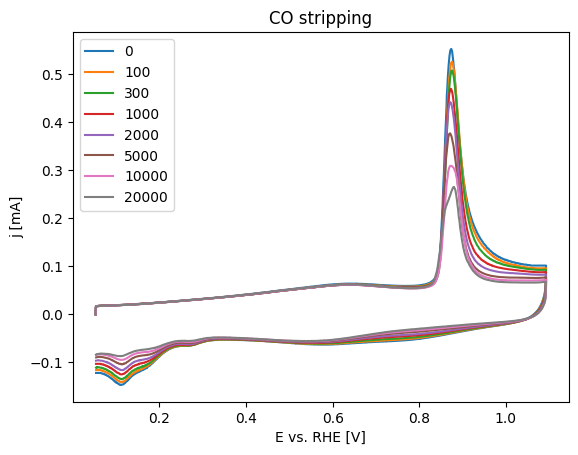

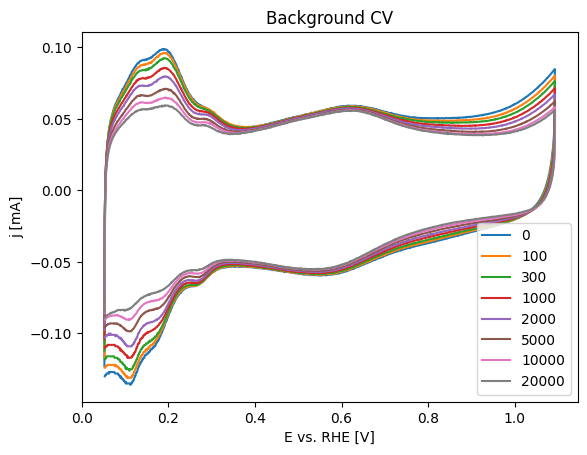

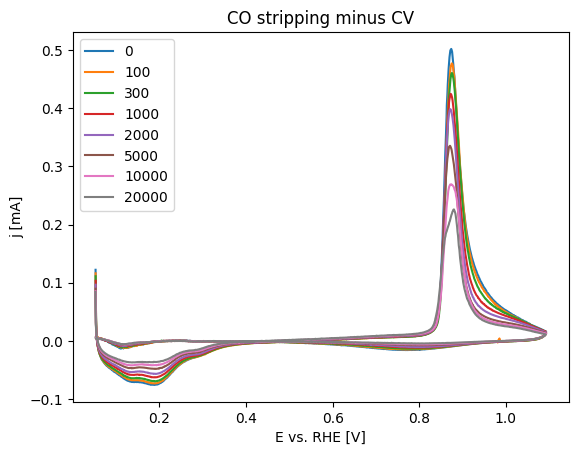

In [55]:
# Adapt to makrolist
cycles = ['0', '100', '300', '1000', '2000', '5000','10000', '20000']  

fig1, ax1 = plt.subplots()
for i in range(0,len(data_RHE[0]),2):
    ax1.plot(data_RHE[:,i], data_RHE[:,i+1])
ax1.legend(cycles, loc='upper left')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [mA]')
ax1.set_title("CO stripping")

# Uncomment to get both background and CO in same plot
fig2, ax2 = plt.subplots()
for i in range(0,len(background_RHE[0]),2):
    ax2.plot(background_RHE[:,i], background_RHE[:,i+1])
    #ax2.plot(data_RHE[:,i], data_RHE[:,i+1])
ax2.legend(cycles)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
#ax2.set_title('CO stripping and CV')
ax2.set_title("Background CV")

fig3, ax3 = plt.subplots()
for i in range(0,len(corrected_data_RHE[0]),2):
    ax3.plot(corrected_data_RHE[:,i], corrected_data_RHE[:,i+1])
ax3.legend(cycles, loc='upper left')
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA]')
ax3.set_title("CO stripping minus CV")

### 7. Analysis
Determining ECSA etc.

In [68]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.09
DL_start = 0.5   #NEED TO TUNE THIS
DL_end = 0.58
tolerence = 0.3

ECSAs = []
specific_ECSAs = []
for i in range(0, len(data_RHE[0]), 2):
    ecsa_calculation = ECSA_calculation(data_RHE[:,i], data_RHE[:,i+1], background_RHE[:,i], background_RHE[:,i+1])

    specific_ECSA, ECSA = ecsa_calculation.calculating_ECSA(
        lower_voltage,
        upper_voltage,
        DL_start,
        DL_end,
        tolerence,
        scan_rate,
        charge_ecsa,
        Pt_mass,
    )

    specific_ECSAs.append(specific_ECSA)
    ECSAs.append(ECSA)
#ecsa_calculation.plotting()

Specific ECSA CO str: 64.53965266782598 m2/g(Pt) 	ECSA CO str: 1.264977192289389 cm2 
Specific ECSA HUPD:   58.86096088770524 m2/g(Pt) 	ECSA HUPD: 1.1536748333990225 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 60.934237980087104 m2/g(Pt) 	ECSA CO str: 1.1943110644097072 cm2 
Specific ECSA HUPD:   60.41293125850038 m2/g(Pt) 	ECSA HUPD: 1.1840934526666074 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 56.664970157269956 m2/g(Pt) 	ECSA CO str: 1.110633415082491 cm2 
Specific ECSA HUPD:   54.12567385470689 m2/g(Pt) 	ECSA HUPD: 1.060863207552255 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 49.9235313831234 m2/g(Pt) 	ECSA CO str: 0.9785012151092186 cm2 
Specific ECSA HUPD:   47.083560472247385 m2/g(Pt) 	ECSA HUPD: 0.9228377852560488 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 44.41511432156626 m

Specific ECSA CO str: 64.53965266782598 m2/g(Pt) 	ECSA CO str: 1.264977192289389 cm2 
Specific ECSA HUPD:   61.32072676360008 m2/g(Pt) 	ECSA HUPD: 1.2018862445665615 cm2
	-------------------------------------------------------------------


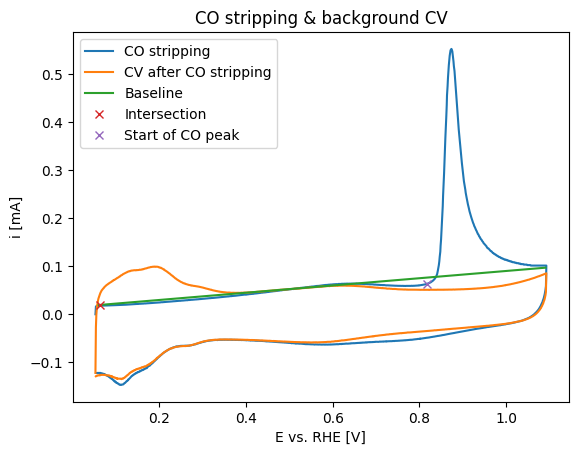

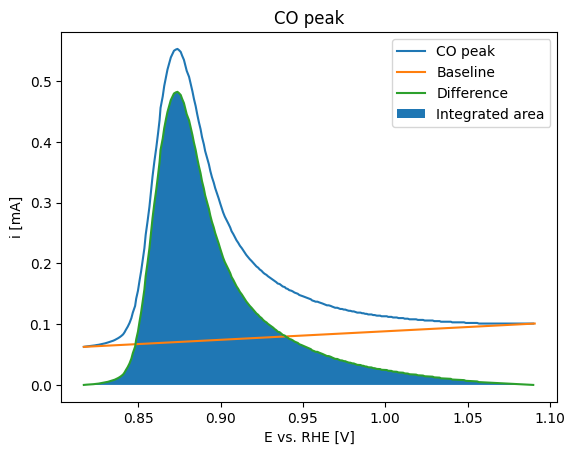

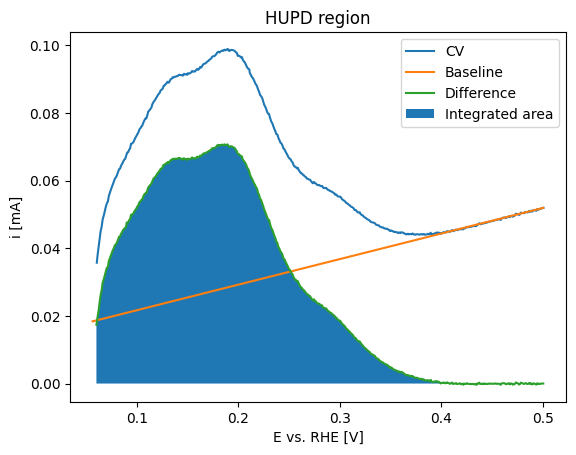

In [69]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.09
DL_start = 0.5   #NEED TO TUNE THIS
DL_end = 0.55
tolerence = 0.25

# Go through all V-I couples in data_matrix
ecsa_calculation = ECSA_calculation(data_RHE[:,0], data_RHE[:,1], background_RHE[:,0], background_RHE[:,1])

specific_ECSA, ECSA = ecsa_calculation.calculating_ECSA(
    lower_voltage,
    upper_voltage,
    DL_start,
    DL_end,
    tolerence,
    scan_rate,
    charge_ecsa,
    Pt_mass,
)
ecsa_calculation.plotting()

##### Plotting the decrease.

[100.0, 99.46093946934984, 97.09899968278435, 90.30646253986345, 82.95393068404799, 72.19616080167235, 65.02720745604843, 58.23777485274926]


C:\Users\go29guw\AppData\Local\Temp\ipykernel_2560\3025489077.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,100000])


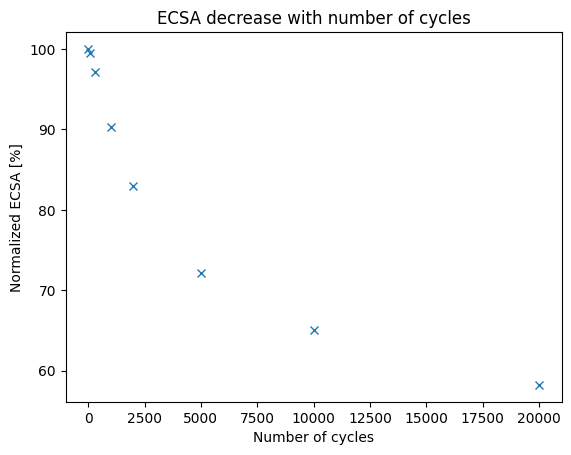

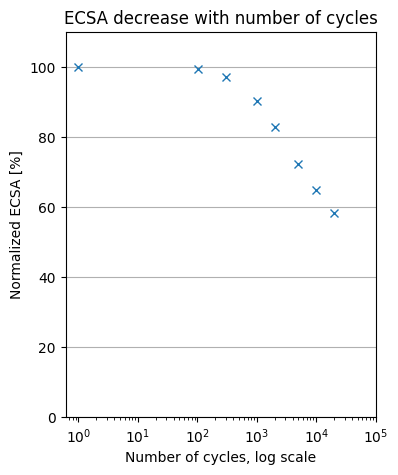

In [24]:
cycles_int = list(map(int, cycles))
CO_areas = [row[0] for row in ECSAs]
normalized_areas = [100*i/CO_areas[0] for i in CO_areas]
print(normalized_areas)

fig1, ax1 = plt.subplots()
ax1.plot(cycles_int, normalized_areas, 'x')
ax1.set_xlabel("Number of cycles")
ax1.set_ylabel("Normalized ECSA [%]")
ax1.set_title("ECSA decrease with number of cycles")

fig2 = plt.figure(figsize=(4,5))
plt.plot([i+1 for i in cycles_int], normalized_areas, 'x')
plt.semilogx()
plt.ylim([0,110])
plt.xlim([0,100000])
plt.xlabel("Number of cycles, log scale")
plt.ylabel("Normalized ECSA [%]")
plt.title("ECSA decrease with number of cycles")
plt.grid(axis='y')

##### Averaging over several measurements: plot with error bars.

C:\Users\go29guw\AppData\Local\Temp\ipykernel_2560\597893653.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,100000])


Text(0.5, 1.0, 'ECSA decrease')

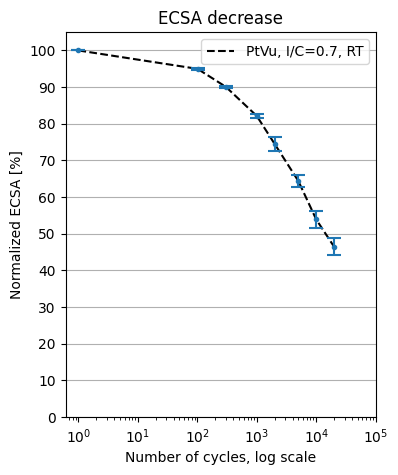

In [71]:
cycles = ['0', '100', '300', '1000', '2000', '5000','10000', '20000']
cycles_int = list(map(int, cycles))
n = 3

mean_values = [100, 94.98126285, 90.09328351, 82.12816358, 74.49110807, 64.40232383, 53.91739891, 46.45974461]
stdv = [0, 0.412192868, 0.496183243, 1.085612341, 3.080946797, 2.999465647, 4.173364097, 4.058083927]
error = [i/np.sqrt(n) for i in stdv]

fig = plt.figure(figsize=(4,5))
ax = plt.subplot()
plt.plot([i+1 for i in cycles_int], mean_values, linestyle='dashed', color='black', label='PtVu, I/C=0.7, RT')
plt.errorbar([i+1 for i in cycles_int], mean_values, yerr=error, fmt='.', capsize=5, capthick=1.5)
plt.grid(axis='y')
plt.semilogx()
plt.ylim([0,105])
ax.set_yticks(ticks=np.arange(0, 101, 10))
plt.xlim([0,100000])
plt.legend()
plt.xlabel("Number of cycles, log scale")
plt.ylabel("Normalized ECSA [%]")
plt.title("ECSA decrease")